<a href="https://colab.research.google.com/github/modraqueeb/IndusVision/blob/main/rockman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

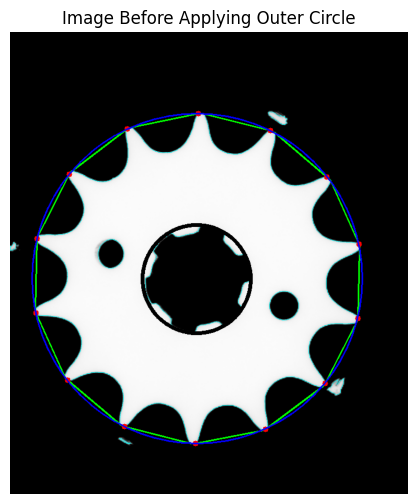

Estimated number of gear teeth: 14
Missing Teeth: None
Estimated number of holes: 3
Estimated outer diameter: 604 pixels
Estimated inner diameter: 198 pixels


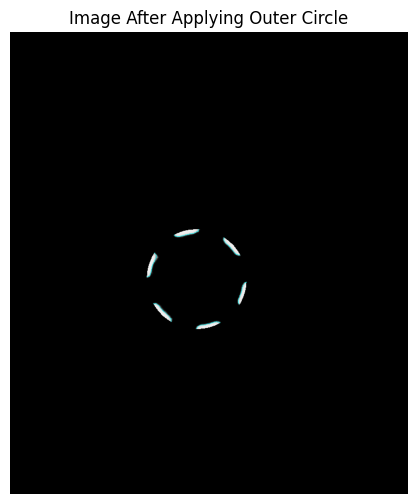

Number of contours after applying the outer circle: 6


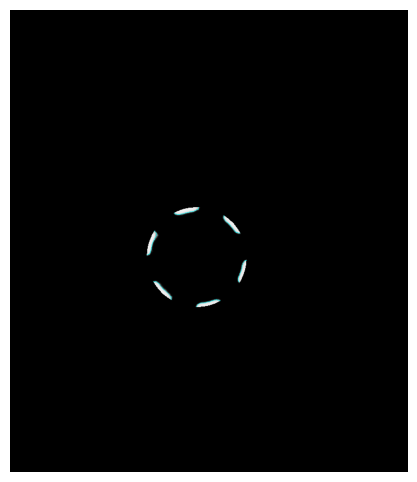

Estimated number of gear teeth: 14
Missing Teeth: None
Estimated number of holes: 3
Estimated outer diameter: 604 pixels
Estimated inner diameter: 198 pixels


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_image(image_path):
    """Load the image in grayscale."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Error: The image file was not found. Check the file path!")
    return cv2.bitwise_not(image)

def preprocess_image(image):
    """Apply thresholding to the image."""
    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return thresh

def get_contours(thresh):
    """Find contours and hierarchy in the thresholded image."""
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours, hierarchy

def analyze_teeth(contour, expected_teeth=14):
    """Analyze gear teeth count and missing teeth."""
    hull = cv2.convexHull(contour)
    distances = [np.linalg.norm(hull[i][0] - hull[(i - 1) % len(hull)][0]) for i in range(len(hull))]
    selected_points = np.array([hull[i][0] for i in range(len(hull)) if distances[i] > 100])

    num_teeth = len(selected_points)
    missing_teeth = max(0, expected_teeth - num_teeth)

    return num_teeth, missing_teeth, selected_points, hull

def analyze_diameters(selected_points, contour, hole_contours):
    """Compute inner and outer diameters of the gear."""
    outer_diameter, inner_diameter = 0, 0
    cx, cy, inner_radius = 0, 0, 0
    x, y, radius = 0, 0, 0

    if selected_points.size > 0:
        (x, y), radius = cv2.minEnclosingCircle(selected_points)
        outer_diameter = 2 * int(radius)

    if hole_contours:
        inner_hole = max(hole_contours, key=cv2.contourArea)
        (cx, cy), inner_radius = cv2.minEnclosingCircle(inner_hole)
        inner_diameter = 2 * int(inner_radius)

    return outer_diameter, inner_diameter, cx, cy, inner_radius, x, y, radius

def count_holes(hierarchy):
    """Count the number of holes in the gear."""
    return sum(1 for i in range(len(hierarchy[0])) if hierarchy[0][i][3] != -1)

def draw_outer_circle(image, cx, cy, inner_radius, outer_radius):
    """Draw the outer circle that covers the gap between inner and outer circles."""
    output_image = image.copy()

    # Draw the outer circle with the calculated outer radius
    cv2.circle(output_image, (int(cx), int(cy)), int(outer_radius), (0, 0, 0), int(outer_radius*1.55-inner_radius/2))

    return output_image

def visualize_results(image, contours, hull, selected_points, outer_diameter, inner_diameter, cx, cy, inner_radius, x, y, radius):
    """Draw contours, teeth, and diameters on the image."""
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Draw all contours in cyan
    cv2.drawContours(output_image, contours, -1, (255, 255, 0), 1)

    # Draw convex hull in green
    cv2.drawContours(output_image, [hull], -1, (0, 255, 0), 2)

    for point in selected_points:
        cv2.circle(output_image, tuple(point), 5, (0, 0, 255), -1)
    if selected_points.size > 0:
        cv2.circle(output_image, (int(x), int(y)), int(radius), (255, 0, 0), 2)
    if inner_diameter > 0:
        cv2.circle(output_image, (int(cx), int(cy)), int(inner_radius), (0, 0, 0), 5)

    return output_image

def display_results(results):
    """Display the processed image and print results."""
    if results["output_image"] is not None:
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(results["output_image"], cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

    # Display the detailed results (just once, after the first image)
    print(f"Estimated number of gear teeth: {results['num_teeth']}")
    print(f"Missing Teeth: {results['missing_teeth'] if results['missing_teeth'] > 0 else 'None'}")
    print(f"Estimated number of holes: {results['num_holes']}")
    print(f"Estimated outer diameter: {results['outer_diameter']} pixels")
    print(f"Estimated inner diameter: {results['inner_diameter']} pixels")

def main(image_path):
    image = load_image(image_path)
    thresh = preprocess_image(image)
    contours, hierarchy = get_contours(thresh)

    if not contours:
        print("No contours found.")
        return

    gear_contour = max(contours, key=cv2.contourArea)
    num_teeth, missing_teeth, selected_points, hull = analyze_teeth(gear_contour)

    hole_contours = [contours[i] for i in range(len(contours)) if hierarchy[0][i][3] != -1]
    outer_diameter, inner_diameter, cx, cy, inner_radius, x, y, radius = analyze_diameters(selected_points, gear_contour, hole_contours)
    num_holes = count_holes(hierarchy)

    # Display the image with contours and convex hull (first image)
    output_image_before = visualize_results(image, contours, hull, selected_points, outer_diameter, inner_diameter, cx, cy, inner_radius, x, y, radius)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(output_image_before, cv2.COLOR_BGR2RGB))
    plt.title("Image Before Applying Outer Circle")
    plt.axis("off")
    plt.show()

    # Print the details after displaying the first image (just once)
    print(f"Estimated number of gear teeth: {num_teeth}")
    print(f"Missing Teeth: {missing_teeth if missing_teeth > 0 else 'None'}")
    print(f"Estimated number of holes: {num_holes}")
    print(f"Estimated outer diameter: {outer_diameter} pixels")
    print(f"Estimated inner diameter: {inner_diameter} pixels")

    # Calculate the outer circle's radius to cover the gap
    outer_radius = inner_radius + (outer_diameter - inner_diameter) / 2

    # Apply the circle function to draw the outer circle
    output_image_after = draw_outer_circle(output_image_before, cx, cy, inner_radius, outer_radius)

    # Convert the image to grayscale before finding contours again
    output_image_after_gray = cv2.cvtColor(output_image_after, cv2.COLOR_BGR2GRAY)

    # Find contours in the second modified image (after applying the outer circle)
    thresh_after = preprocess_image(output_image_after_gray)  # Threshold the grayscale image again
    contours_after, _ = get_contours(thresh_after)

    # Display the image after applying the outer circle (second image)
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(output_image_after, cv2.COLOR_BGR2RGB))
    plt.title("Image After Applying Outer Circle")
    plt.axis("off")
    plt.show()

    # Print the number of contours in the modified image
    print(f"Number of contours after applying the outer circle: {len(contours_after)}")

    results = {
        "num_teeth": num_teeth,
        "missing_teeth": missing_teeth,
        "num_holes": num_holes,
        "outer_diameter": outer_diameter,
        "inner_diameter": inner_diameter,
        "output_image": output_image_after
    }

    # Final result display (after applying the outer circle)
    display_results(results)

# Example Usage
image_path = r"/content/g1 (1).BMP"
main(image_path)
